<a href="https://colab.research.google.com/github/faynercosta/faynercosta/blob/main/HODL_SP23_Recitation_1_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning - Review and Extensions

* Based on [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python-second-edition?gclid=CjwKCAjw9aiIBhA1EiwAJ_GTSlKgxc4qopKHPsFWryOoTz7fvhvhzYSjEsgQ-bG1R51QSGppISywpBoClcIQAvD_BwE) by Francois Chollett



In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# initialize the seeds of different random number generators so that the 
# results will be the same every time the notebook is run
keras.utils.set_random_seed(42)

In [2]:
!wget -q -P ./ https://www.dropbox.com/s/w07liww46kgxo1m/handbags-shoes.zip
!unzip -qq handbags-shoes.zip

## Data Pre-processing



---



---

We will split the data into train/validation/test sets so that we can monitor overfitting etc.     

In [3]:
import os, shutil, pathlib

base_dir = pathlib.Path("/content/handbags-shoes")


In [4]:
for category in ('handbags', 'shoes'):
  fnames = os.listdir(base_dir/category)
  dir = base_dir /'train' / category
  os.makedirs(dir)
  for fname in fnames[:50]:
      shutil.copyfile(src=base_dir/category/fname,
                      dst=dir/fname)
  dir = base_dir /'validation' / category
  os.makedirs(dir)
  for fname in fnames[50:75]:
      shutil.copyfile(src=base_dir/category/fname,
                      dst=dir/fname)
  dir = base_dir /'test' / category
  os.makedirs(dir)
  for fname in fnames[75:]:
      shutil.copyfile(src=base_dir/category/fname,
                      dst=dir/fname)

The code above creates this directory structure:

handbags_vs_shoes/  
...train/   
......handbags/         
......shoes/    
...validation/    
......handbags/       
......shoes/         
...test/    
......handbags/     
......shoes/   




---



---




When working with image JPEGs, we will follow this process:

1.   Read in the JPEGs
2.   Convert the JPEGs into tensors 
3.   Resize them to a standard size (since web-scraped images may be in different sizes)
5.   Group them into batches (we’ll use batches of 32 images).


Fortunately, Keras gives us a single function that does all these in one shot! (Ref: [image manipulation functions](https://keras.io/api/preprocessing/image/))


In [5]:
train_dataset = keras.utils.image_dataset_from_directory(
    base_dir / 'train',
    image_size=(224, 224),
    batch_size=32)

validation_dataset = keras.utils.image_dataset_from_directory(
    base_dir / 'validation',
    image_size=(224, 224),
    batch_size=32)

test_dataset = keras.utils.image_dataset_from_directory(
    base_dir / 'test',
    image_size=(224, 224),
    batch_size=32)


Found 95 files belonging to 2 classes.
Found 50 files belonging to 2 classes.
Found 40 files belonging to 2 classes.


**Less than 100 examples in the training set!!** 



Let's look at a few examples.

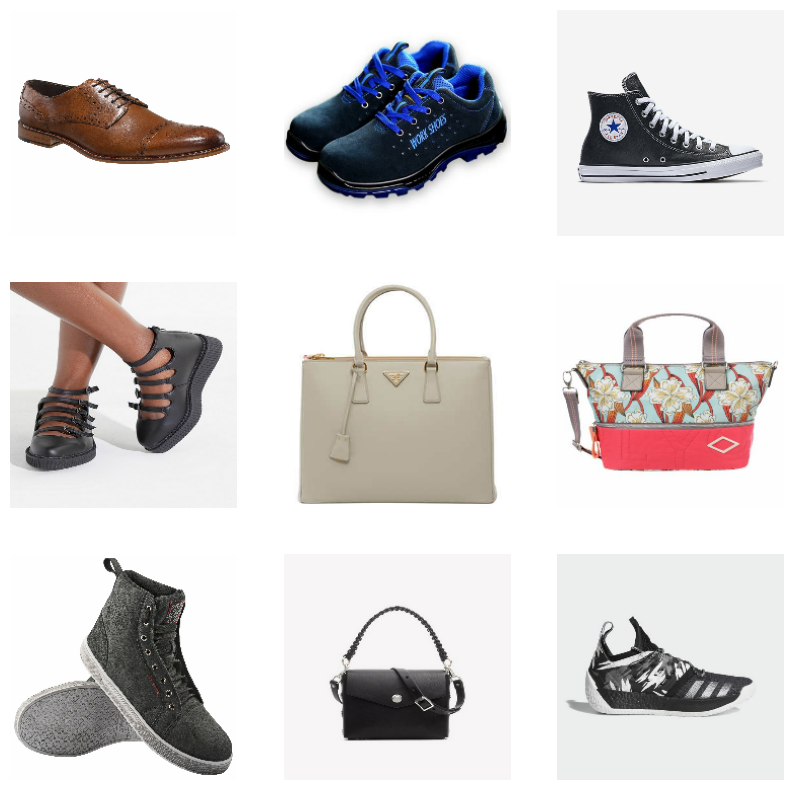

In [7]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

## Implementing a Basic CNN and counting its parameters 






---



---



We will slightly modify the CNN from lecture by adding one small fully connected layer before the output layer.

In [8]:
input = keras.Input(shape=(224,224,3))
h = keras.layers.Rescaling(1./255)(input)


# convolutional layer!
h = keras.layers.Conv2D(32, kernel_size=(2, 2), activation="relu", name="Conv_1")(h) 
# pooling layer
h = keras.layers.MaxPool2D()(h) 


# convolutional layer!
h = keras.layers.Conv2D(32, kernel_size=(2, 2), activation="relu", name="Conv_2")(h) 
# pooling layer
h = keras.layers.MaxPool2D()(h) 


# Flatten Everything 
h = keras.layers.Flatten()(h)

#Run through the Dense Layer
h = keras.layers.Dense(16, activation='relu')(h)

output = keras.layers.Dense(1, activation="sigmoid")(h)

model = keras.Model(input, output)

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 Conv_1 (Conv2D)             (None, 223, 223, 32)      416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 Conv_2 (Conv2D)             (None, 110, 110, 32)      4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 55, 55, 32)       0         
 2D)                                                         

Let's calculate the total number of parameters, one-by-one.

In [10]:
num_param_conv1 = 32 * (2 * 2 * 3) + 32
num_param_conv2 = 32  *  (2 * 2 * 32) + 32
size_flatten = 55 * 55 * 32
num_param_dense = size_flatten * 16 + 16
output = 16 * 1 + 1
total = num_param_conv1 + num_param_conv2 + num_param_dense + output

print(f"""
# Params Conv_1: {num_param_conv1},
# Params Conv_2: {num_param_conv2},
# Params Dense_1: {num_param_dense},
# Params Output: {output}
#### TOTAL PARAMS: {total}
""")


# Params Conv_1: 416,
# Params Conv_2: 4128,
# Params Dense_1: 1548816,
# Params Output: 17
#### TOTAL PARAMS: 1553377



## Accessing the layers and weights of a model

Before moving forward, let's inspect the layers of this neural network. 

This can be useful to debug or interpret what the NN is doing, and could also be useful later when doing finetuning in a transfer learning task.

First, we can retrieve the list of layers of the model:

In [11]:
model.layers

Let's zoom in the Dense layer we just added.




We can check the weigths of the layer by calling the attribute `weight` on the layer.

In [12]:
dense_layer = model.layers[-2]
# dense_layer
dense_layer.weights

[<tf.Variable 'dense/kernel:0' shape=(96800, 16) dtype=float32, numpy=
 array([[ 5.3980220e-03, -3.6357716e-04, -1.8535838e-03, ...,
          7.7532846e-03,  1.1999579e-03, -3.2613617e-03],
        [-5.9421500e-04,  9.8583288e-04, -2.0153169e-03, ...,
         -4.7029988e-03,  4.4071106e-03,  3.9860215e-03],
        [-7.3850858e-03,  1.6305530e-03,  7.8000631e-03, ...,
         -8.6423196e-04, -1.5332364e-05,  4.2369282e-03],
        ...,
        [ 2.3366688e-03,  1.2471275e-03, -1.6889363e-03, ...,
          3.3412986e-03,  3.4314822e-03, -5.9022130e-03],
        [ 4.2204959e-03,  2.3464113e-04,  2.3527518e-03, ...,
          2.3668082e-03,  4.5615966e-03,  6.5489328e-03],
        [ 6.2144678e-03,  1.9268282e-03,  6.2228674e-03, ...,
         -5.8826688e-03, -6.6082049e-03,  7.6126978e-03]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(16,) dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32)>]

In [13]:
# Get only coefficients weights
dense_layer.weights[0]
dense_layer.kernel

# Get only bias
dense_layer.weights[1]
dense_layer.bias

# Get non-bias weights from first neuron in layer
dense_layer.weights[0][:, 0]

<tf.Tensor: shape=(96800,), dtype=float32, numpy=
array([ 0.00539802, -0.00059422, -0.00738509, ...,  0.00233667,
        0.0042205 ,  0.00621447], dtype=float32)>

Let's look at the first Convolutional layer. What are the weights?

Let's recall that the first Conv2D layer has 416 parameters. 

In [14]:
conv_layer_1 = model.layers[2]
conv_layer_1.weights

[<tf.Variable 'Conv_1/kernel:0' shape=(2, 2, 3, 32) dtype=float32, numpy=
 array([[[[ 1.48304388e-01,  6.73346072e-02, -5.84993064e-02,
            1.86313376e-01, -1.74699306e-01,  6.30715638e-02,
            1.94805458e-01, -1.37497455e-01,  9.84969735e-03,
            5.41396290e-02, -1.71239108e-01, -2.22101063e-02,
            1.92956284e-01, -1.22799575e-02,  1.21991336e-03,
            1.09996185e-01, -1.99223340e-01, -1.27366409e-01,
            5.89656830e-03, -1.79517224e-01, -1.91433161e-01,
            1.44071832e-01,  1.72003493e-01, -9.83174443e-02,
            1.48860350e-01, -1.54240191e-01, -1.56153291e-02,
            2.59693116e-02,  2.76130587e-02, -1.24144703e-01,
           -1.20198637e-01,  2.02533081e-01],
          [-1.61519662e-01, -2.33463198e-02, -9.72625762e-02,
           -1.56912103e-01,  9.65303630e-02, -1.31523490e-01,
            7.50635713e-02,  6.22793883e-02, -1.89368844e-01,
            2.63477415e-02, -6.86801374e-02, -4.68498915e-02,
            

The weights on the first filter:

In [15]:
first_filter = conv_layer_1.weights[0][:, :, :, 0]
first_filter

# Look at each channel separately
red = first_filter[:, :, 0]
green = first_filter[:, :, 1]
blue = first_filter[:, :, 2]

print(f'R:\n {red}\n')
print(f'G:\n {green}\n')
print(f'B:\n {blue}')

R:
 [[ 0.14830439  0.12548028]
 [-0.02593407  0.08614399]]

G:
 [[-0.16151966  0.05072783]
 [-0.0651117  -0.08403245]]

B:
 [[-0.07614549  0.03057145]
 [ 0.039914    0.16642316]]


In [16]:
first_filter = conv_layer_1.weights[0][:, :, :, 0]
first_filter

# Look at each channel separately
red = first_filter[:, :, 0]
green = first_filter[:, :, 1]
blue = first_filter[:, :, 2]

print(f'R:\n {red}\n')
print(f'G:\n {green}\n')
print(f'B:\n {blue}')

R:
 [[ 0.14830439  0.12548028]
 [-0.02593407  0.08614399]]

G:
 [[-0.16151966  0.05072783]
 [-0.0651117  -0.08403245]]

B:
 [[-0.07614549  0.03057145]
 [ 0.039914    0.16642316]]


Another relevant attribute of a model (and its layers) is the `trainable` attribute.

This tell us whether the weights of a model/layer will be optimized when we call `model.fit`.

Normally, models created from scratch are set to `trainable = True` i.e., all weights in all layers will be subject to optimization.

In [17]:
model.trainable

True

However, layers can be **selectively** set to `trainable = False`, when we exclude the weights of those layers from being modified by the optimizer. This is called "**freezing**" a layer or model.

Let's look at our layers:

In [18]:
# ( 9 layers in total)
model.layers

In [19]:
for layer in model.layers:
  print(layer.trainable)

True
True
True
True
True
True
True
True
True


We can change this manually if we wish to freeze one of the layers:

In [20]:
# Let's freeze the first and second Conv layer
model.layers[2].trainable = False
model.layers[4].trainable = False

for layer in model.layers:
  print(layer.trainable)

True
True
False
True
False
True
True
True
True


Now, if we retrain the model, the weights in the 'frozen' layers won't change i.e. will be untouched by the optimizer.

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 Conv_1 (Conv2D)             (None, 223, 223, 32)      416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 Conv_2 (Conv2D)             (None, 110, 110, 32)      4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 55, 55, 32)       0         
 2D)                                                         

Notice the "Non-trainable params" number above.

In [22]:
# We can unfreeze these layers easily as well
model.layers[2].trainable = True
model.layers[4].trainable = True

for layer in model.layers:
  print(layer.trainable)

True
True
True
True
True
True
True
True
True


## Review of Transfer Learning model built in class




---

We will work with ResNet-50 since it comes pre-packaged with Keras. 

Check out all the pre-trained models available in [Keras](https://keras.io/api/applications/) and in [Tensorflow](https://www.tensorflow.org/hub)


In [23]:
resnet50_base = keras.applications.ResNet50(
  weights='imagenet',
  input_tensor=None,
  include_top=False,
  input_shape=None)

94765736/94765736 [==============================] - 1s 0us/step


In [24]:
resnet50_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_2[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                        

Next, we run our dataset through "headless ResNet" to get the transformed, "smart" inputs.

In [25]:
def get_features_and_labels(dataset):
  all_features = []
  all_labels = []
  for images, labels in dataset:
    preprocessed_images = keras.applications.resnet50.preprocess_input(images)
    features = resnet50_base.predict(preprocessed_images)
    all_features.append(features)
    all_labels.append(labels)
  return np.concatenate(all_features), np.concatenate(all_labels)

In [26]:
train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 1s 535ms/step


In [27]:
print(f"""
# Features Shape: {train_features.shape},
# PLabels Shape: {train_labels.shape}
""")




# Features Shape: (95, 7, 7, 2048),
# PLabels Shape: (95,)



The input is a 7 x 7 x 2048 cube (i.e. tensor)!

These tensors coming out of "headless" ResNet are smart representations and we can simply attach them to a small NN, as described in the PPT.

We use a regularization layer that we haven't yet used: `Dropout`. 

In [29]:
input = keras.Input(shape=(7, 7, 2048))
h = keras.layers.Flatten()(input)
h = keras.layers.Dense(256, activation="relu")(h)
h = keras.layers.Dropout(0.5)(h)
output = keras.layers.Dense(1, activation="sigmoid")(h)

model = keras.Model(input, output)

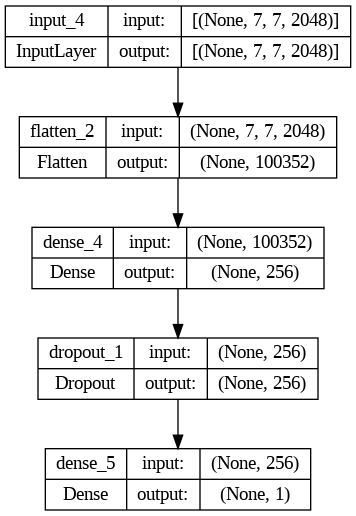

In [30]:
keras.utils.plot_model(model, show_shapes=True)

In [31]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 7, 7, 2048)]      0         
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 dense_4 (Dense)             (None, 256)               25690368  
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 25,690,625
Trainable params: 25,690,625
Non-trainable params: 0
_________________________________________________________________


In [33]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(
  train_features, train_labels,
  epochs=10,
  validation_data=(val_features, val_labels))

Epoch 1/10
3/3 [==============================] - 1s 169ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 1.4254 - val_accuracy: 0.9800
Epoch 2/10
3/3 [==============================] - 0s 49ms/step - loss: 2.7663e-37 - accuracy: 1.0000 - val_loss: 1.4254 - val_accuracy: 0.9800
Epoch 3/10
3/3 [==============================] - 0s 46ms/step - loss: 2.8309e-38 - accuracy: 1.0000 - val_loss: 1.4254 - val_accuracy: 0.9800
Epoch 4/10
3/3 [==============================] - 0s 62ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 1.4254 - val_accuracy: 0.9800
Epoch 5/10
3/3 [==============================] - 0s 44ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 1.4254 - val_accuracy: 0.9800
Epoch 6/10
3/3 [==============================] - 0s 44ms/step - loss: 1.8316e-24 - accuracy: 1.0000 - val_loss: 1.4254 - val_accuracy: 0.9800
Epoch 7/10
3/3 [==============================] - 0s 64ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 1.4254 - val_accuracy: 0.980

In [34]:
# handy function to visualize how the changes with each epoch

def plot_learning_curve(history):
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(accuracy) + 1)
  plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
  plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.show()

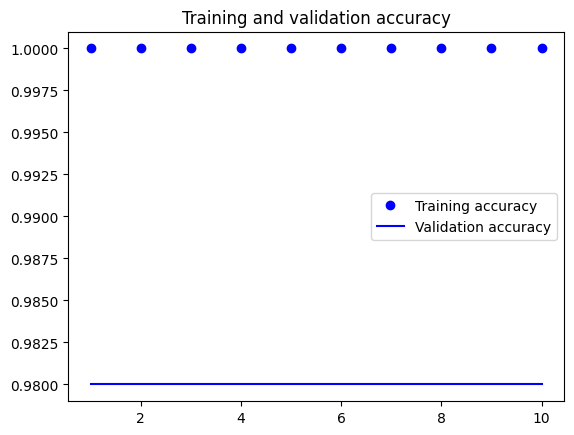

In [35]:
plot_learning_curve(history)

In [36]:
model.evaluate(test_features, test_labels)

2/2 [==============================] - 0s 8ms/step - loss: 0.9252 - accuracy: 0.9750


[0.9252229928970337, 0.9750000238418579]

OK, let's test it **LIVE** with my laptop's webcam.

In [37]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename



In [38]:
def predict_image(im):
  #Adjust the image and prepross it to fit the resnet50_base model expected format and shape
  img = keras.preprocessing.image.load_img(im, target_size=(224,224))
  arr = keras.preprocessing.image.img_to_array(img)
  arr = np.expand_dims(arr, axis=0)

  #Run through a pre-processing layer that scales colors across channels and fits the new pattern to the ImageNet pattern by averaging the channels
  arr = keras.applications.resnet50.preprocess_input(arr)


  #Run through the resnet50 base model to extract the smart features we talked about
  arr = resnet50_base(arr)

  #Run the resulting smart features through our simples single dense layer model
  predc = model.predict(arr)
  pred = "SHOE" if predc > 0.5 else "HANDBAG"
  print("***********************************\n\n")
  print(f"...........it is a {pred}!")
  print("\n\n************************************\n\n")

<IPython.core.display.Javascript object>

Saved to photo.jpg


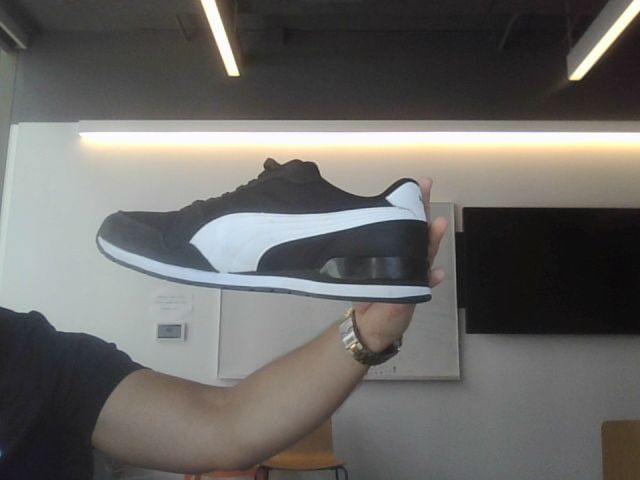

1/1 [==============================] - 0s 49ms/step
***********************************


...........it is a SHOE!


************************************




In [39]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
  predict_image(filename)
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

## [Extra] Extending the Transfer Learning Approach



Earlier, we ran our images through ResNet50 and used the output from ResNet50 as the input to a little NN that we trained. In this process, the weights of ResNet50 were untouched by the training - only the weights of the little NN were optimized.

But we can build an even more advanced model by connecting 'headless' ResNet to our little NN and treating the whole thing as a single model that we train.

When we do this, however, we won't train tall layers of ResNet, but only a few layers - Specifically just the final layer, given the little amount of data we have. How? We freeze all but the few layers closest to the output head i.e., closest to where our little NN connects to headless ResNet.

In [42]:
# How many layers?
len(resnet50_base.layers)

22

In [43]:
# Are they trainable?
for layers in resnet50_base.layers:
  print(layers.trainable)

False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True
True
True


In [44]:
# Re download the model with original weights
resnet50_base = keras.applications.VGG19(
  weights='imagenet',
  input_tensor=None,
  include_top=False,
  input_shape=None)

#  we can freeze all layers ...
resnet50_base.trainable = False
# ... and unfreeze only the final layer
for layer in resnet50_base.layers[-1:]:
  layer.trainable = True

for layer in resnet50_base.layers:
  print(layer.trainable)

# Equivalently, this freezes all but the last 10 layers
# for layer in resnet50_base.layers[:-10]:
#   layer.trainable = False

# for layer in resnet50_base.layers:
#   print(layer.trainable)



False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True


Now we can build a full model where the first part is the partially frozen ResNet, and the second part is our little NN.

In [45]:
input = keras.Input(shape=(224, 224, 3))

h = keras.layers.Rescaling(1./255)(input)

# the headless ResNet part of our model
h = keras.applications.resnet50.preprocess_input(h)
h = resnet50_base(h)

# the simple NN part of our model
h = keras.layers.Flatten()(h)
h = keras.layers.Dense(256, activation="relu")(h)
h = keras.layers.Dropout(0.5)(h)
output = keras.layers.Dense(1, activation="sigmoid")(h)

model2 = keras.Model(input, output)
model2.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg19 (Functional)          (None, None, None, 512)   20024384  
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0         
                                                           

In [46]:
model2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history2 = model2.fit(train_dataset, 
                    epochs=10,
                    validation_data=validation_dataset)

# Notice how we trained the previous model using the representation of the features instead of the the actual datasets:
# history = model.fit(train_features, train_labels,
#   epochs=10,
#   validation_data=(val_features, val_labels))

Epoch 1/10
3/3 [==============================] - 16s 5s/step - loss: 6.2138 - accuracy: 0.4947 - val_loss: 3.7824 - val_accuracy: 0.5000
Epoch 2/10
3/3 [==============================] - 3s 807ms/step - loss: 2.5163 - accuracy: 0.4526 - val_loss: 2.3927 - val_accuracy: 0.5000
Epoch 3/10
3/3 [==============================] - 2s 443ms/step - loss: 2.2872 - accuracy: 0.5263 - val_loss: 0.6872 - val_accuracy: 0.5200
Epoch 4/10
3/3 [==============================] - 2s 506ms/step - loss: 1.0609 - accuracy: 0.5684 - val_loss: 1.1445 - val_accuracy: 0.5000
Epoch 5/10
3/3 [==============================] - 1s 403ms/step - loss: 1.1351 - accuracy: 0.5053 - val_loss: 0.6005 - val_accuracy: 0.6200
Epoch 6/10
3/3 [==============================] - 2s 789ms/step - loss: 0.8356 - accuracy: 0.5789 - val_loss: 0.9297 - val_accuracy: 0.5000
Epoch 7/10
3/3 [==============================] - 2s 402ms/step - loss: 0.9136 - accuracy: 0.5474 - val_loss: 0.5779 - val_accuracy: 0.8000
Epoch 8/10
3/3 [======

In [47]:
# Check the accuracy on the test set: 
model2.evaluate(test_dataset)

2/2 [==============================] - 2s 1s/step - loss: 0.6335 - accuracy: 0.5500


[0.633450984954834, 0.550000011920929]

Remember that our previous model, trained on the data representation had virtually 100% of Accuracy! 

What happened? ResNet50 was trained using a million datappoints.


With this small amount of datapoints that we currently provided, instead of improving the overall ResNet performance for our particular case, by trying to retrain the sofisticated final layer, we just decalibrated the weights.

Imagine that you're performing a very complex hand calculation on a particular mathematical problem, and getting it right for many pages. However, on the final multiplication you just multiply by the wrong number. What happens? The whole calculation will become wrong!

## Including Data Augmentation



The basic idea of augmentation is to slightly alter the image so that the value of the dependent variable (i.e. the category that it belongs to) doesn't change. For instance, if you rotate the image of a handbag by 10 degrees or zoom in on it slightly, the content of the image doesn't change; it is still a handbag.

By applying these transformations repeatedly to an image, you can create new images and thereby increase the size of the dataset almost effortlessly.

Researchers have developed a list of these transformations that you can apply to images and Keras provides them out of the box as different kinds of layers.

To demonstrate, here's a little Keras model that applies three transformations to an incoming image.

In [ ]:
data_augmentation = keras.Sequential(
    [
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(0.1),
        keras.layers.RandomZoom(0.2),
    ]
)

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
resnet50_base = keras.applications.ResNet50(
  weights='imagenet',
  input_tensor=None,
  include_top=False,
  input_shape=None)

resnet50_base.trainable = False

# Same building process, but now with the data_agumentation added right after the input
input = keras.Input(shape=(224, 224, 3))
h = data_augmentation(input)

h = keras.layers.Rescaling(1./255)(input)

# the headless ResNet part of our model
h = keras.applications.resnet50.preprocess_input(h)
h = resnet50_base(h)

# the simple NN part of our model
h = keras.layers.Flatten()(h)
h = keras.layers.Dense(256, activation="relu")(h)
h = keras.layers.Dropout(0.5)(h)
output = keras.layers.Dense(1, activation="sigmoid")(h)

model3 = keras.Model(input, output)
model3.summary()


In [ ]:
model3.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history3 = model3.fit(train_dataset, 
                    epochs=10,
                    validation_data=validation_dataset)

In [ ]:
# Notice the difference to the previous model: Taking out the pre-process layer that are baked in the model, as well as the prediction done by the resnet50_base
def predict_image2(im):
  img = keras.preprocessing.image.load_img(im, target_size=(224,224))
  arr = keras.preprocessing.image.img_to_array(img)
  arr = np.expand_dims(arr, axis=0)
  # arr = keras.applications.resnet50.preprocess_input(arr)
  # arr = resnet50_base(arr)
  pred = model3.predict(arr)
  pred = "SHOE" if pred > 0.5 else "HANDBAG"
  print("************************************\n\n")
  print(f"...........it is a {pred}!")
  print("\n\n************************************\n\n")

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
  predict_image2(filename)
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))